# Predicting choice of Contraceptives

This [dataset](https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice) is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The samples are married women who were either not pregnant or do not know if they were at the time of interview. The problem is to predict the current contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics.

## 2. Understanding the Data Set

<p style="text-align: justify;"><strong>Independent Variables</strong></p>
<pre><strong>Age:   </strong>Wife's age (numerical)
<strong>Education:</strong> &nbsp;   Wife's education (categorical) 1=low, 2, 3, 4=high 
<strong>H_education:</strong>    Husband's education (categorical) 1=low, 2, 3, 4=high 
<strong>Num_Child:</strong> Number of children ever born (numerical)
<strong>Religion:</strong>       Wife's religion (binary) 0=Non-Islam, 1=Islam 
<strong>Employ:</strong>      Wife's now working? (binary) 0=Yes, 1=No
<strong>H_occupation:</strong>   Husband's occupation (categorical) 1, 2, 3, 4 
<strong>Living_Standard:</strong>  Standard-of-living index (categorical) 1=low, 2, 3, 4=high 
<strong>Media_Exposure:</strong>  Media exposure (binary) 0=Good, 1=Not good 
</pre>

<p><strong>Dependent Variables</strong></p>
<pre><strong>Contraceptive:</strong>  Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term
</pre> 

In [1]:
import pandas as pd
import numpy as np

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Embedding, Merge, Flatten

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
np.random.seed(42)
random_state = 42

## 3. Importing Data Set and Basic Data Exploration

In [4]:
cmc_df = pd.read_csv('data/cmc.data',header=None,names=['Age','Education','H_education',
                                                     'Num_Child','Religion', 'Employ',
                                                     'H_occupation','Living_Standard',
                                                     'Media_Exposure','Contraceptive'])
cmc_df.head()

,Age,Education,H_education,Num_Child,Religion,Employ,H_occupation,Living_Standard,Media_Exposure,Contraceptive
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [5]:
cmc_df.shape

(1473, 10)

In [6]:
# check if any column has null values
cmc_df.isnull().any()

Age                False
Education          False
H_education        False
Num_Child          False
Religion           False
Employ             False
H_occupation       False
Living_Standard    False
Media_Exposure     False
Contraceptive      False
dtype: bool

In [7]:
# The info() method is useful to get a quick description of the data, in particular the total number of rows, 
# and each attribute’s type and number of non-null values
cmc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
Age                1473 non-null int64
Education          1473 non-null int64
H_education        1473 non-null int64
Num_Child          1473 non-null int64
Religion           1473 non-null int64
Employ             1473 non-null int64
H_occupation       1473 non-null int64
Living_Standard    1473 non-null int64
Media_Exposure     1473 non-null int64
Contraceptive      1473 non-null int64
dtypes: int64(10)
memory usage: 115.2 KB


In [8]:
cmc_df.dtypes

Age                int64
Education          int64
H_education        int64
Num_Child          int64
Religion           int64
Employ             int64
H_occupation       int64
Living_Standard    int64
Media_Exposure     int64
Contraceptive      int64
dtype: object

In [9]:
cat_cols = ['Education','H_education', 'Religion', 'Employ', 'H_occupation','Living_Standard', 'Media_Exposure','Contraceptive']
num_cols = ['Age', 'Num_Child']

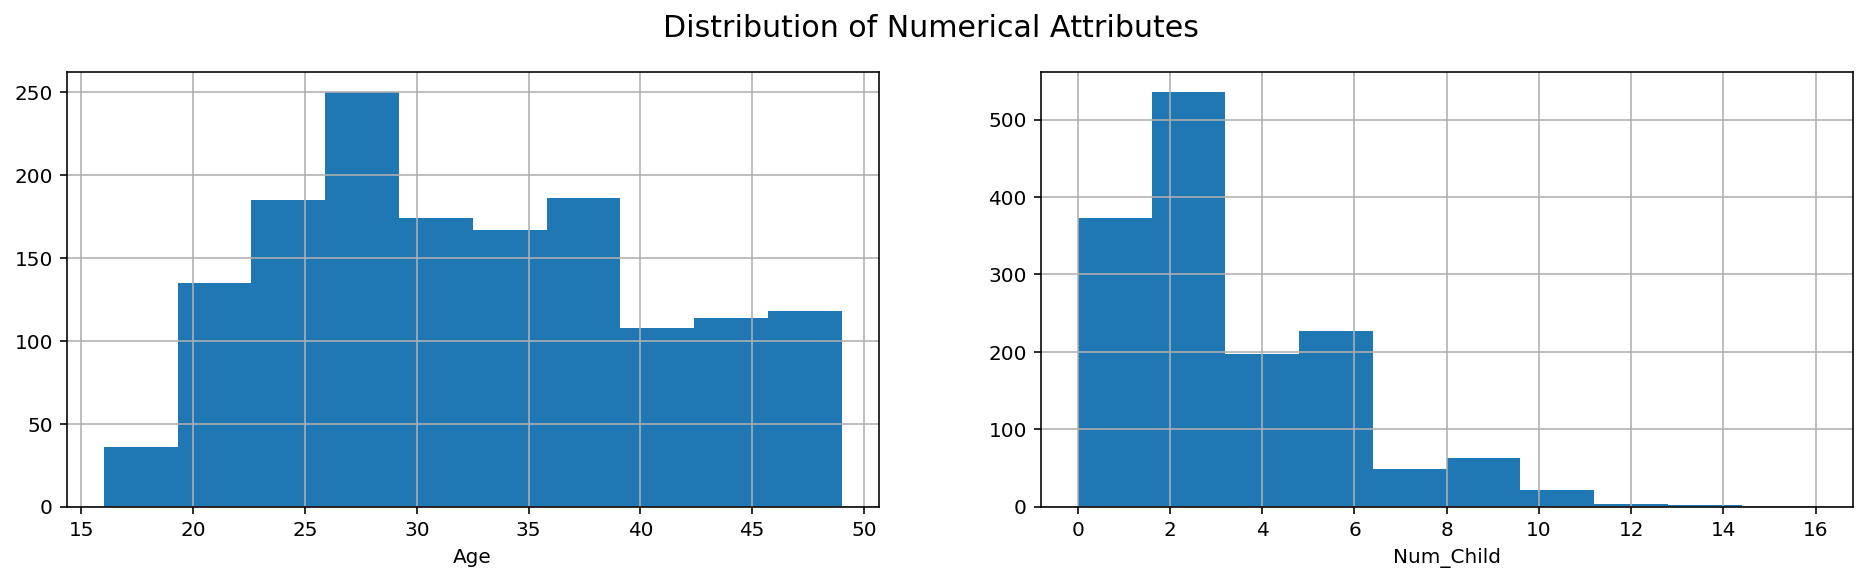

In [10]:
# Check the distribution of the numerical attributes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
cmc_df['Age'].hist(ax=ax[0])
ax[0].set(xlabel='Age')
cmc_df['Num_Child'].hist(ax=ax[1])
ax[1].set(xlabel='Num_Child')
fig.suptitle('Distribution of Numerical Attributes', fontsize=15);

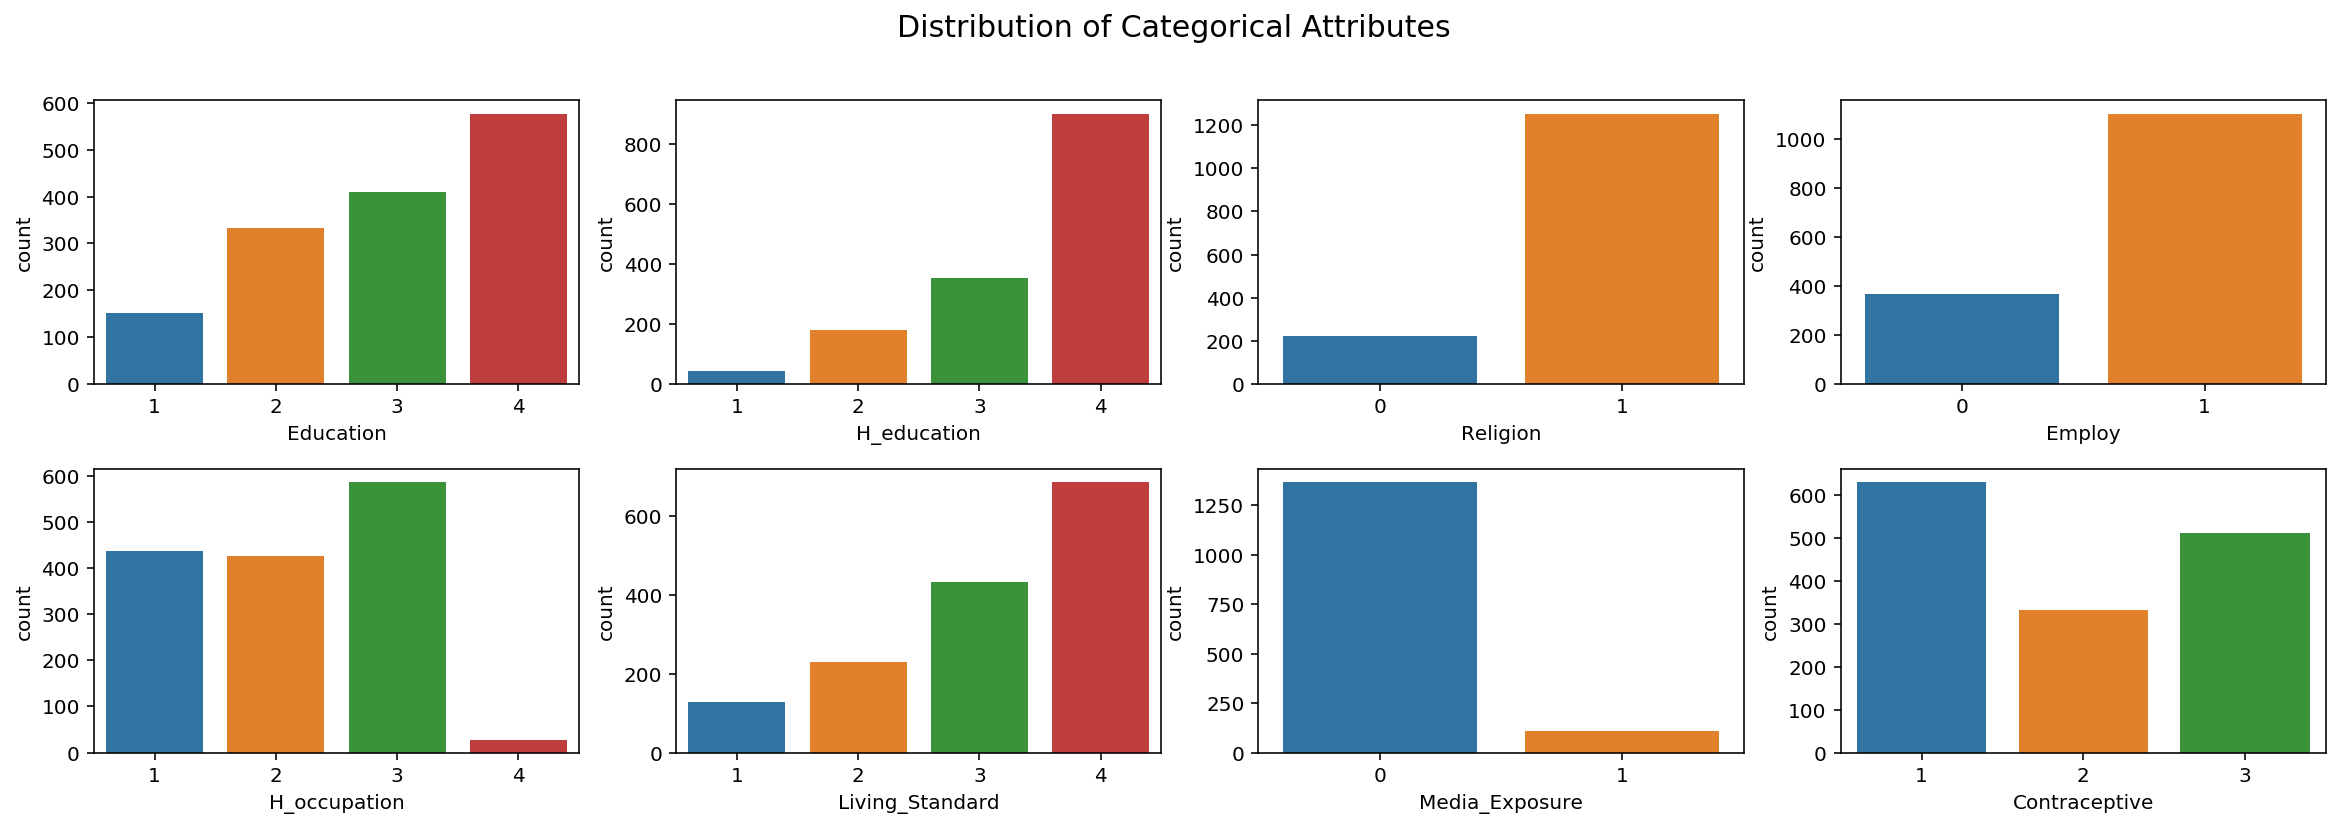

In [11]:
# Check the distribution of the categorical attributes
fig = plt.figure(figsize=(20,6))
for i, col in zip(range(8), cat_cols):
    ax = fig.add_subplot(2, 4, i + 1)
    sns.countplot(x=col, data=cmc_df, ax=ax)
plt.subplots_adjust(hspace=0.3)
fig.suptitle('Distribution of Categorical Attributes', fontsize=15);

**How does the other features correlate with the contraceptive?**

In [12]:
contraceptive_corr = cmc_df.corr()['Contraceptive']
contraceptive_corr.reindex(contraceptive_corr.abs().sort_values(ascending=False).index)

Contraceptive      1.000000
Age               -0.162953
Education          0.149777
Media_Exposure    -0.119206
H_education        0.103226
Living_Standard    0.091149
Num_Child          0.082772
Employ             0.054438
Religion          -0.025271
H_occupation       0.018161
Name: Contraceptive, dtype: float64

**Correlation between Features**

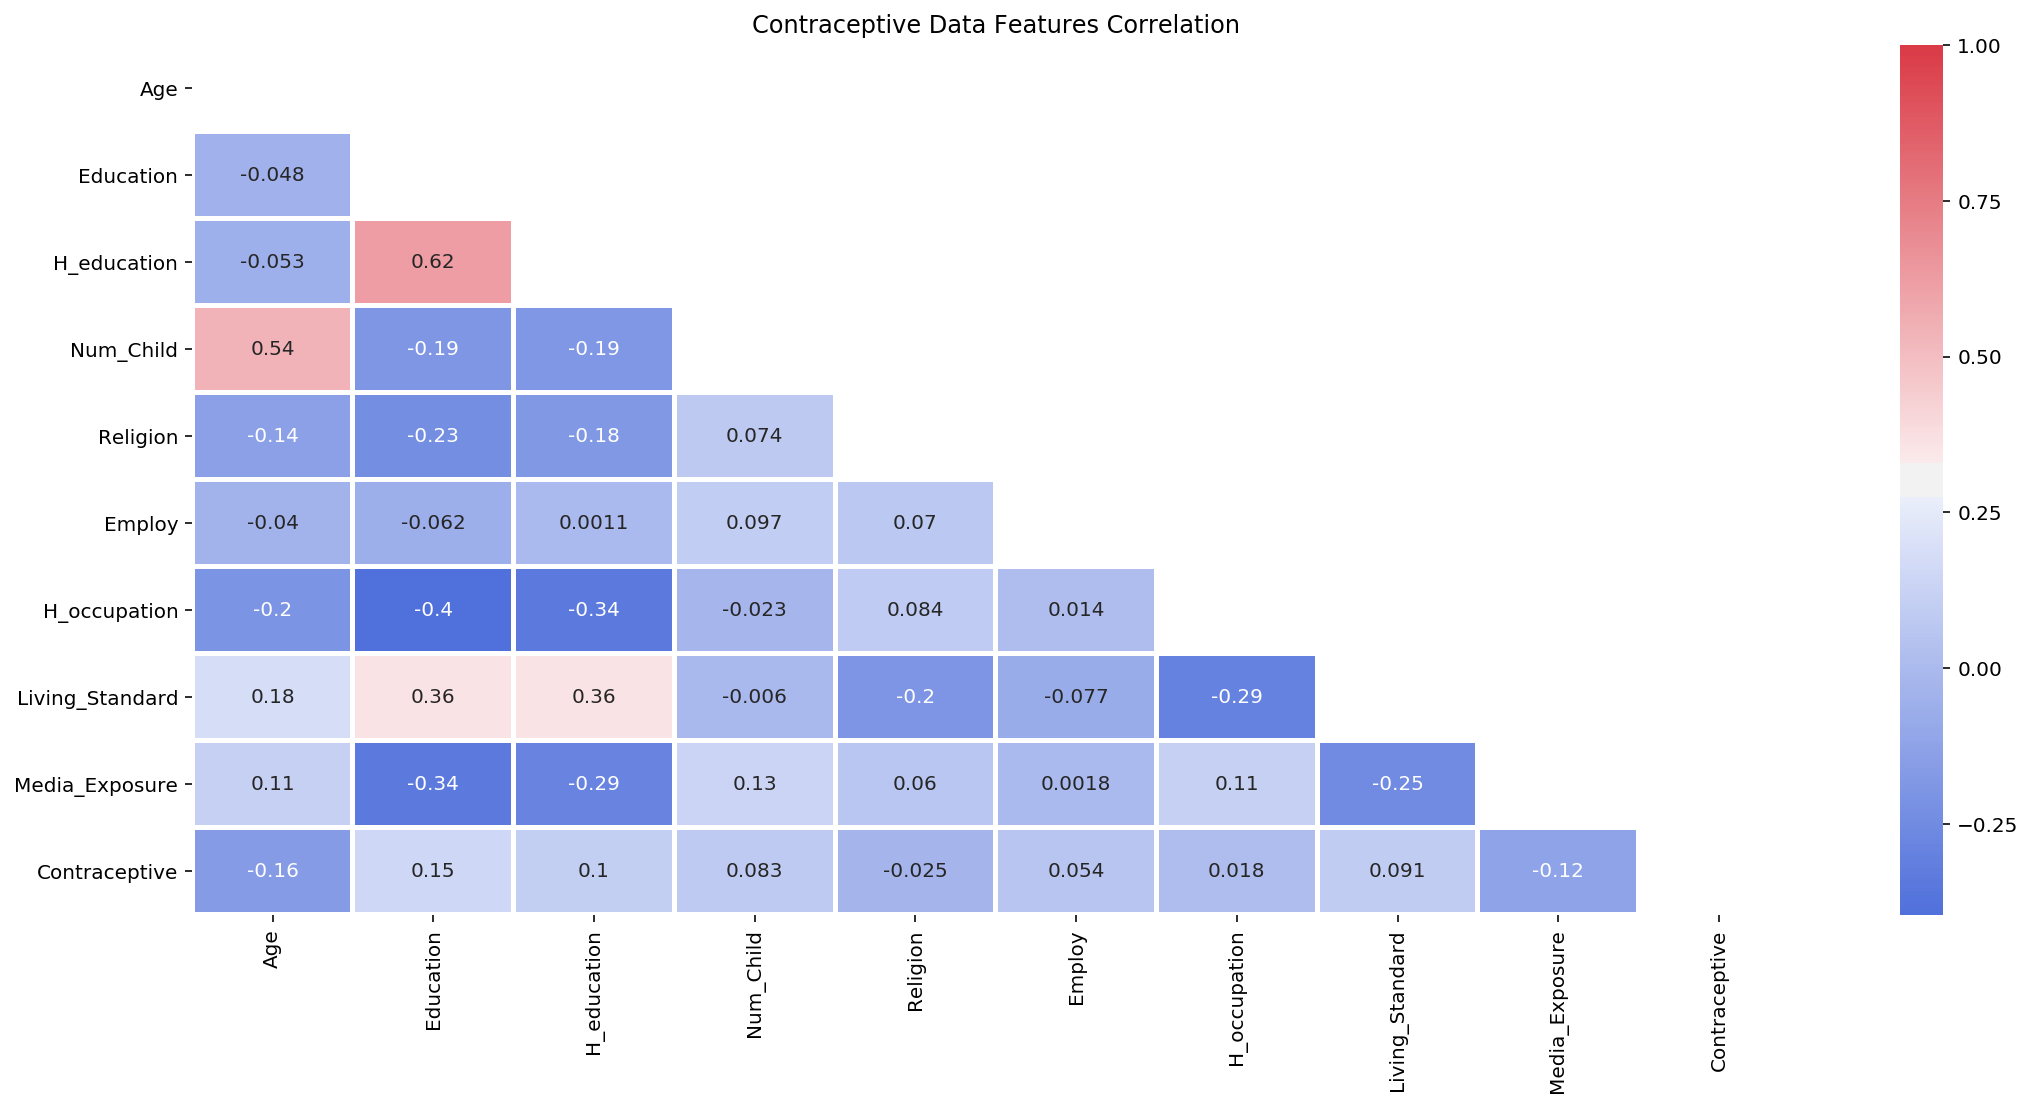

In [13]:
# Compute the correlation matrix
corr_matrix = cmc_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18, 8))
plt.title('Contraceptive Data Features Correlation')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, square=False, cmap=cmap, mask=mask, ax=ax, annot=True, fmt='.2g', linewidths=2);
#sns.heatmap(corrMatt, mask=mask, vmax=1.2, square=True, annot=True, fmt='.2g', ax=ax);

## 4. Pre-Processing the data

In [14]:
all_data = cmc_df.drop(['Contraceptive'], axis=1)
all_labels = cmc_df['Contraceptive']

### 4.1 Handling Categorical Attributes : One-Hot encoding
Since some of the categorical attributes starts from 1 we need to subract one from them to make them start from zero

In [15]:
all_data[['Education', 'H_education', 'H_occupation', 'Living_Standard']] \
        = all_data[['Education', 'H_education', 'H_occupation', 'Living_Standard']] - 1
all_labels = all_labels - 1

**Using pandas get_dmmies() method:**

We can leverage pandas get_dummies() method to perform one-hot encoding.

In [16]:
pd.get_dummies(all_data['Education'], prefix='Edu').head(5)

,Edu_0,Edu_1,Edu_2,Edu_3
0,0,1,0,0
1,1,0,0,0
2,0,1,0,0
3,0,0,1,0
4,0,0,1,0


### 4.2 Handling Numerical Attributes : Feature Scaling

In Standardization we first subtract the mean value (so standardized values always have a zero mean), and then divide by the variance so that the resulting distribution has unit variance. We will use scikit-learn's `StandardScaler` for this.

In [17]:
scaler = StandardScaler()
all_data[['Age','Num_Child']] = scaler.fit_transform(all_data[['Age','Num_Child']])

### 4.3 Prepare train and test sets for Machine Learning

In [18]:
one_hot_X = pd.concat([all_data, pd.get_dummies(all_data['Education'], prefix='Edu'), 
                        pd.get_dummies(all_data['H_education'], prefix='H_edu'), 
                        pd.get_dummies(all_data['H_occupation'], prefix='H_occu'),
                        pd.get_dummies(all_data['Living_Standard'], prefix='Liv_Std')], axis=1)

In [19]:
one_hot_X = one_hot_X.drop(['Education', 'H_education', 'H_occupation', 'Living_Standard'], axis=1)

In [20]:
pd.options.display.max_columns = 30
one_hot_X.head(10)

,Age,Num_Child,Religion,Employ,Media_Exposure,Edu_0,Edu_1,Edu_2,Edu_3,H_edu_0,H_edu_1,H_edu_2,H_edu_3,H_occu_0,H_occu_1,H_occu_2,H_occu_3,Liv_Std_0,Liv_Std_1,Liv_Std_2,Liv_Std_3
0,-1.038167,-0.110856,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,1.515194,2.858078,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
2,1.272017,1.585678,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,1.150428,2.433945,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
4,0.420897,2.009811,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0
5,-1.646111,-1.383257,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0
6,0.664074,1.161544,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
7,-1.402933,-0.959123,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0
8,-0.673401,-0.110856,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
9,1.515194,2.009811,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0


In [21]:
one_hot_X.columns

Index(['Age', 'Num_Child', 'Religion', 'Employ', 'Media_Exposure', 'Edu_0',
       'Edu_1', 'Edu_2', 'Edu_3', 'H_edu_0', 'H_edu_1', 'H_edu_2', 'H_edu_3',
       'H_occu_0', 'H_occu_1', 'H_occu_2', 'H_occu_3', 'Liv_Std_0',
       'Liv_Std_1', 'Liv_Std_2', 'Liv_Std_3'],
      dtype='object')

In [22]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
one_hot_y = lb.fit_transform(all_labels)

In [23]:
X_train, X_test, y_train, y_test, labels_train, labels_test = \
train_test_split(one_hot_X.values, one_hot_y, all_labels, test_size=0.2, shuffle=True, stratify=all_labels, \
                 random_state=random_state)

## 5. Train a Multilayer Perceptron

In [24]:
# Build a model using Keras Functional API
input_1 = Input(shape=(X_train.shape[1],))
hidden1 = Dense(units=12, activation='relu')(input_1)
output = Dense(3, activation='softmax')(hidden1)
model = Model(inputs=[input_1], outputs=output)

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                264       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 39        
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________


In [26]:
from keras.utils import plot_model
plot_model(model, to_file='images/multilayer_perceptron.png', show_shapes=True, show_layer_names=True)

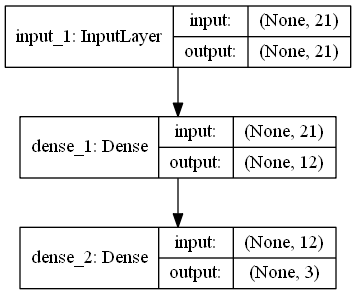

In [27]:
from IPython.display import Image
Image(filename='images/multilayer_perceptron.png')

In [28]:
epochs=100
batch_size=32

In [29]:
from keras.optimizers import Adagrad
optimizer = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0).history

**Plotting Train vs Validation Loss:**

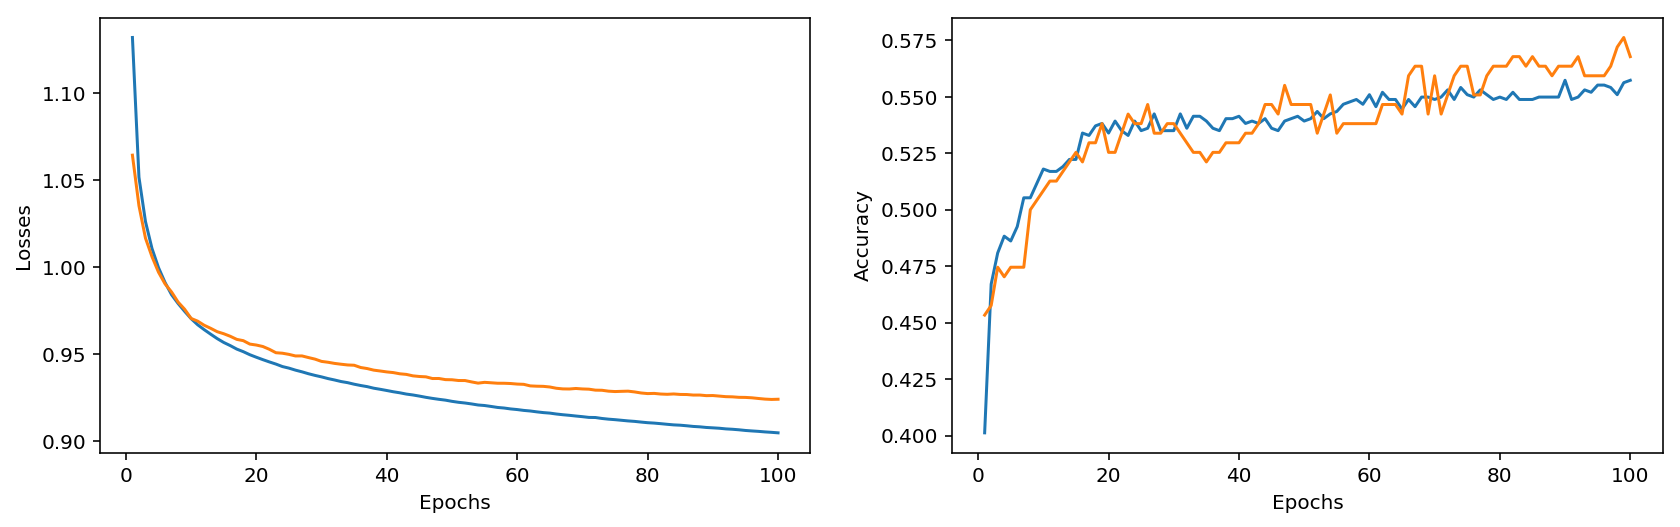

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax[0].plot(range(1, epochs + 1), history['loss'])
ax[0].plot(range(1, epochs + 1), history['val_loss'])
_ = ax[0].set(xlabel='Epochs', ylabel='Losses')
ax[1].plot(range(1, epochs + 1), history['acc'])
ax[1].plot(range(1, epochs + 1), history['val_acc'])
_ = ax[1].set(xlabel='Epochs', ylabel='Accuracy')

In [31]:
for w in model.get_weights():
    print(w.shape)

(21, 12)
(12,)
(12, 3)
(3,)


In [32]:
# The attribute `model.metrics_names` will give you the display labels for the scalar outputs.
model.metrics_names

['loss', 'acc']

In [33]:
# Returns the loss value & metrics values for the model in test mode.
los, acc = model.evaluate(X_test, y_test, batch_size=32)
los, acc

295/295 [==============================] - ETA: 0s


(0.94262706304000599, 0.55932203450445406)

In [34]:
# Evaluate the test set
model.predict(X_test[:10])

array([[ 0.10775429,  0.25844184,  0.6338039 ],
       [ 0.34642205,  0.1554089 ,  0.49816912],
       [ 0.3928937 ,  0.3211605 ,  0.28594583],
       [ 0.06318493,  0.30485666,  0.63195843],
       [ 0.37673238,  0.29529592,  0.32797176],
       [ 0.45029756,  0.15681544,  0.39288697],
       [ 0.95559579,  0.02031826,  0.02408596],
       [ 0.87193143,  0.07446551,  0.05360305],
       [ 0.71323228,  0.11433034,  0.17243743],
       [ 0.45663261,  0.30056477,  0.24280265]], dtype=float32)

## 6. Train a Multilayer Perceptron with Embeddings

I chose attributes 'Living_Standard' and 'Education' to create Embeddings for those features. The features are one-hot encoded first and then converted in to Embedding layer of size 10. The attributes ['Age','Num_Child','Employ','Media_Exposure'] will be kept as is.

**One-Hot encoding of Categorical Attributes:**

In [35]:
living_standard_max_categories = cmc_df['Living_Standard'].max()
living_standard_max_categories

4

In [36]:
living_standard_one_hot_encoded = pd.get_dummies(cmc_df['Living_Standard'], prefix='Liv_Std')
living_standard_one_hot_encoded.head(5)

,Liv_Std_1,Liv_Std_2,Liv_Std_3,Liv_Std_4
0,0,0,1,0
1,0,0,0,1
2,0,0,0,1
3,0,0,1,0
4,0,1,0,0


In [37]:
education_max_categories = cmc_df['Education'].max()
education_max_categories

4

In [38]:
education_one_hot_encoded = pd.get_dummies(cmc_df['Education'], prefix='Edu')
education_one_hot_encoded.head(5)

,Edu_1,Edu_2,Edu_3,Edu_4
0,0,1,0,0
1,1,0,0,0
2,0,1,0,0
3,0,0,1,0
4,0,0,1,0


**Feature Scaling of Numerical Attributes:**

In [39]:
non_embedding_data = cmc_df[['Age','Num_Child','Employ','Media_Exposure']].copy()
all_labels = cmc_df['Contraceptive']

In [40]:
scaler = StandardScaler()
non_embedding_data[['Age','Num_Child']] = scaler.fit_transform(non_embedding_data[['Age','Num_Child']])

**Prepare train and test sets for Machine Learning:**

In [41]:
one_hot_X = pd.concat([non_embedding_data, 
                       education_one_hot_encoded,
                       living_standard_one_hot_encoded], axis=1)

In [42]:
pd.options.display.max_columns = 30
one_hot_X.head(10)

,Age,Num_Child,Employ,Media_Exposure,Edu_1,Edu_2,Edu_3,Edu_4,Liv_Std_1,Liv_Std_2,Liv_Std_3,Liv_Std_4
0,-1.038167,-0.110856,1,0,0,1,0,0,0,0,1,0
1,1.515194,2.858078,1,0,1,0,0,0,0,0,0,1
2,1.272017,1.585678,1,0,0,1,0,0,0,0,0,1
3,1.150428,2.433945,1,0,0,0,1,0,0,0,1,0
4,0.420897,2.009811,1,0,0,0,1,0,0,1,0,0
5,-1.646111,-1.383257,1,0,0,0,0,1,0,0,1,0
6,0.664074,1.161544,1,0,0,1,0,0,0,1,0,0
7,-1.402933,-0.959123,0,0,0,0,1,0,0,1,0,0
8,-0.673401,-0.110856,1,0,0,1,0,0,0,0,0,1
9,1.515194,2.009811,1,1,1,0,0,0,0,1,0,0


In [43]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
one_hot_y = lb.fit_transform(all_labels)

In [44]:
X_train, X_test, y_train, y_test, labels_train, labels_test = \
train_test_split(one_hot_X.values, one_hot_y, all_labels, test_size=0.2, shuffle=True, stratify=all_labels, \
                 random_state=random_state)

**Create the Neural Network with Embedding Layers:**

In [45]:
# Input layer for ['Age','Num_Child','Employ','Media_Exposure']
input_1 = Input(shape=(4,), name='non-embedding-input')
dense1 = Dense(units=4)(input_1)

# Input layer for Education
input_2 = Input(shape=(4,), name='education')
edu = Embedding(input_dim=4, output_dim=10, input_length=1)(input_2)
flat1 = Flatten()(edu)

# Input layer for Living Standard
input_3 = Input(shape=(4,), name='living_standard')
liv = Embedding(input_dim=4, output_dim=10, input_length=1)(input_3)
flat2 = Flatten()(liv)

merge = keras.layers.concatenate([dense1, flat1, flat2])

hidden1 = Dense(units=12, activation='relu')(merge)
output = Dense(units=3, activation='softmax')(hidden1)

model = Model(inputs=[input_1, input_2, input_3], outputs=output)

In [46]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
education (InputLayer)          (None, 4)            0                                            
__________________________________________________________________________________________________
living_standard (InputLayer)    (None, 4)            0                                            
__________________________________________________________________________________________________
non-embedding-input (InputLayer (None, 4)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        40          education[0][0]                  
__________________________________________________________________________________________________
embedding_

In [47]:
from keras.utils import plot_model
plot_model(model, to_file='images/multilayer_perceptron_with_embedding.png', show_shapes=True, show_layer_names=True)

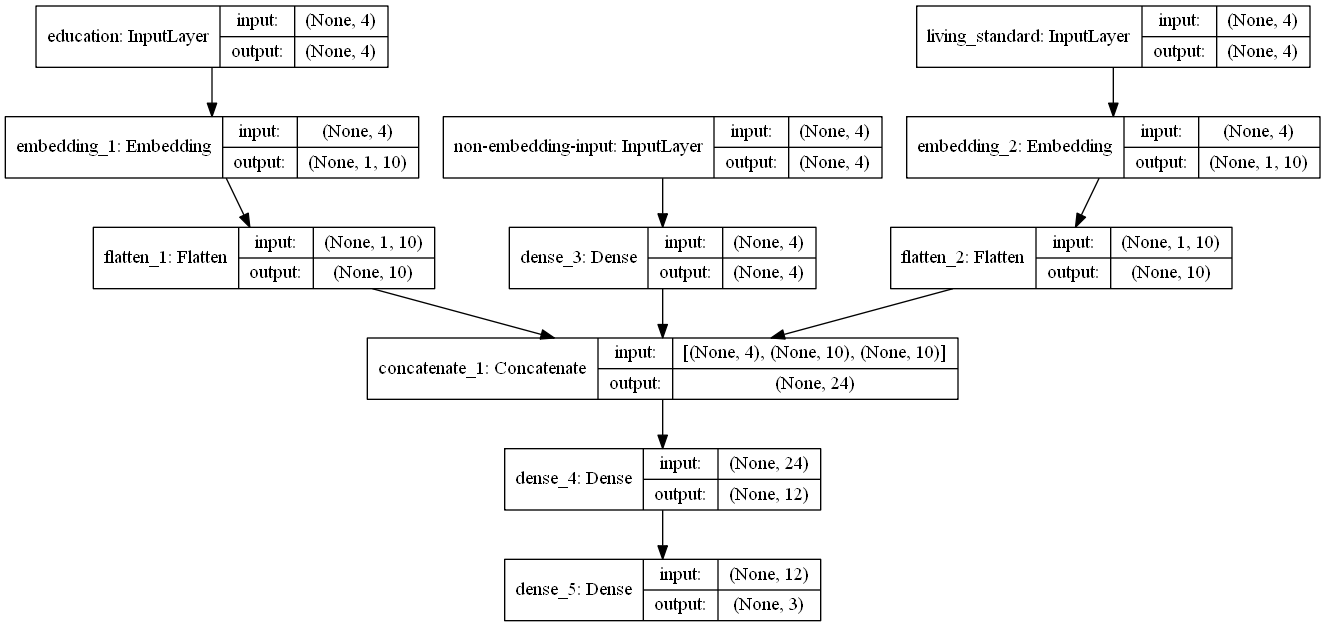

In [48]:
from IPython.display import Image
Image(filename='images/multilayer_perceptron_with_embedding.png')

In [49]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [50]:
from keras.optimizers import Adagrad
optimizer = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([X_train[:,0:4], X_train[:,4:8], X_train[:,8:12]], y_train, validation_split=0.2, 
                    epochs=epochs, batch_size=batch_size, verbose=0).history

InvalidArgumentError: Matrix size-incompatible: In[0]: [32,84], In[1]: [24,12]
	 [[Node: dense_4/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](concatenate_1/concat, dense_4/kernel/read)]]

Caused by op 'dense_4/MatMul', defined at:
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-140879f981ea>", line 17, in <module>
    hidden1 = Dense(units=12, activation='relu')(merge)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\keras-2.0.8-py3.5.egg\keras\engine\topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\keras-2.0.8-py3.5.egg\keras\layers\core.py", line 843, in call
    output = K.dot(inputs, self.kernel)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\keras-2.0.8-py3.5.egg\keras\backend\tensorflow_backend.py", line 1050, in dot
    out = tf.matmul(x, y)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1844, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 1289, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "D:\Work\Anaconda3\envs\tensorflow-cpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Matrix size-incompatible: In[0]: [32,84], In[1]: [24,12]
	 [[Node: dense_4/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](concatenate_1/concat, dense_4/kernel/read)]]
